In [700]:
import pandas as pd
import sklearn.tree as sktree
import scipy as sp
import os
path="./데이터/"
filename=os.listdir(path)

## 변수설정

### Target(Y)

target = 침수여부

In [701]:
target=pd.read_csv("./데이터/침수지역2022.csv")

위의 데이터는 침수지역의 빈도(frequency)이므로 바꿔야함

In [702]:
print('한번이라도 침수가 일어난 지역수(행정동) :',target["ADM_NM"].nunique())

한번이라도 침수가 일어난 지역수(행정동) : 277


In [703]:
target["ADM_NM"]

0         우이동
1         우이동
2         우이동
3        영등포동
4         송중동
        ...  
8882      청파동
8883      한남동
8884    원효로2동
8885      동선동
8886    북가좌2동
Name: ADM_NM, Length: 8887, dtype: object

### Feature(X)

In [704]:
filename

['B422. 서울시 누적강수량(월평균) 공간데이터',
 'B422. 서울시 누적강수량(월평균) 공간데이터.zip.001',
 'elevation.csv',
 'LSMD_CONT_UQ123_서울',
 'mnum_data.csv',
 'ufid_data.csv',
 'Z_SIS_ASIT_SOILDRA_AREA.xlsx',
 '경사도.xlsx',
 '고도',
 '공시지가_2019평균.csv',
 '공시지가_2019평균.xlsx',
 '공원(UTM).csv',
 '기초생활수급자+65세이상.csv',
 '기초수급자.csv',
 '노인.csv',
 '노인층.csv',
 '데이터',
 '데이터.zip',
 '도로 중복값제거.csv',
 '도로현황(도로율)_20231015181102.csv',
 '동별_인구_고도_배수등급_공시지가.csv',
 '동별_인구_고도_배수등급_공시지가_결합.csv',
 '동별_인구_고도_배수등급_공시지가_결합_인코딩.csv',
 '모아보기.csv',
 '반출_행정동_소득가구_수정2차.xlsx',
 '배수등급양호비율.csv',
 '서울시 행정동.csv',
 '서울시_강우량_정보_2021년',
 '서울시_강우량_정보_2022년',
 '서울시_강우량_정보_2022년 (2).zip',
 '서울시_강우량_정보_2022년.zip',
 '서울시_행정동별_인구밀도_2023.csv',
 '수문.csv',
 '실폭하천.csv',
 '암거.csv',
 '여성.csv',
 '장애인.csv',
 '재해위험지구_경계도.csv',
 '제방.csv',
 '제방암거수문_있다없다.csv',
 '제방암거수문개수.csv',
 '침수지역2022.csv',
 '침수흔적도2022.csv',
 '하천까지의_거리.csv']

In [705]:
경사도=pd.read_excel(path+"/경사도.xlsx")
도로율=pd.read_csv(path+"/"+"도로현황(도로율)_20231015181102.csv")
제방암거수문=pd.read_csv(path+"/"+'제방암거수문_있다없다.csv')
행정동소득분위=pd.read_excel(path+"/"+"반출_행정동_소득가구_수정2차.xlsx")
배수등급양호비율=pd.read_csv(path+"/"+"배수등급양호비율.csv")
하천까지의거리=pd.read_csv(path+"/"+'하천까지의_거리.csv')
인구밀도=pd.read_csv(path+"/"+'서울시_행정동별_인구밀도_2023.csv')
    

사회인프라

In [706]:
장애인=pd.read_csv(path+"/"+"장애인.csv")
노인=pd.read_csv(path+"/"+'노인.csv')
기초수급자=pd.read_csv(path+"/"+"기초수급자.csv")
기초수급자_65세이상=pd.read_csv(path+"/"+'기초생활수급자+65세이상.csv')

강우량

In [707]:
path3=path+'서울시_강우량_정보_2022년/'

In [708]:
rain_dict={}
for i in range(1,13):
    rain_dict[i]=pd.read_csv(path3+f'서울시_강우량_정보_2022년{i}월.csv',encoding='euc-kr')

In [709]:
rain_data=pd.concat([rain_dict[i][rain_dict[i]["10분우량"]!=0] for i in range(1,13)])
rain_agg=rain_data.groupby(["구청명"])["10분우량"].agg(["sum","count"])
rain_agg.rename(columns=dict(zip(["sum","count"],["누적강수량","10분당 측정(횟수)"])),inplace=True)
rain_agg.index.rename(None,inplace=True)

In [710]:
rain_agg["추정시우량(연간)"]=rain_agg["누적강수량"]/(rain_agg["10분당 측정(횟수)"]/6)

In [711]:
rain_agg.index.rename("시군구",inplace=True)
rain_agg.reset_index(inplace=True)

In [712]:
구면적=pd.DataFrame(인구밀도.groupby(["구"])["면적 (k㎡)"].sum()).reset_index()
구면적.rename(columns={"구":"시군구"},inplace=True)

In [713]:
rain_agg=pd.merge(rain_agg,구면적)
rain_agg["추정면적당시우량(연간)"]=rain_agg["추정시우량(연간)"]/rain_agg["면적 (k㎡)"]

In [714]:
rain_agg

,시군구,누적강수량,10분당 측정(횟수),추정시우량(연간),면적 (k㎡),추정면적당시우량(연간)
0,강남구,5187.0,3025,10.288264,39.51,0.260396
1,강동구,3426.5,2300,8.938696,24.59,0.363509
2,강북구,1803.5,1382,7.829957,23.60,0.331778
3,강서구,2690.5,2053,7.863127,41.44,0.189747
4,관악구,3461.0,2176,9.543199,29.57,0.322732
5,광진구,1887.0,1353,8.368071,17.06,0.490508
6,구로구,3246.5,1962,9.928135,20.12,0.493446
7,금천구,3270.0,2091,9.383070,13.02,0.720666
8,노원구,3290.5,2312,8.539360,35.44,0.240953
9,도봉구,1932.0,1435,8.078049,20.65,0.391189


### 데이터 병합

행정동 단위
> 경사도, 행정공시지가, 배수등급양호비율, 하천까지의 거리, 제방수문암거

In [715]:
import PublicDataReader as pdr
행정동코드 = pdr.code_hdong()
import numpy as np
행정동=행정동코드[행정동코드["시도명"]=="서울특별시"][["시군구명","읍면동명"]]
행정동.index=행정동.index.astype('int')
행정동["시군구명"]=행정동["시군구명"].str.strip()
행정동["읍면동명"]=행정동["읍면동명"].str.strip()
행정동=행정동[행정동["시군구명"]!=""][행정동["읍면동명"]!=""]

출처: 행정기관(행정동) 및 관할구역(법정동) 변경내역(2023. 7. 3. 시행)


C:\Users\yis82\AppData\Local\Temp\ipykernel_86680\2488655424.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  행정동=행정동[행정동["시군구명"]!=""][행정동["읍면동명"]!=""]


----------

In [716]:
per_경사도=pd.DataFrame(경사도.groupby(["ADM_NM"])["경사도"].mean())
per_경사도.reset_index(inplace=True)

In [717]:
pre_경사도=pd.merge(경사도[["GU_NAME","ADM_NM"]],per_경사도,how='left')
pre_경사도["경사도(%)"]=pre_경사도["경사도"]*100
pre_경사도.drop_duplicates(["ADM_NM"],inplace=True)

In [718]:
pre_경사도

,GU_NAME,ADM_NM,경사도,경사도(%)
0,종로구,이화동,0.078333,7.833333
1,종로구,숭인2동,0.053125,5.312500
2,종로구,혜화동,0.078333,7.833333
3,중구,광희동,0.072500,7.250000
4,중구,을지로동,0.040000,4.000000
...,...,...,...,...
3234,관악구,난곡동,0.231667,23.166667
3427,금천구,시흥2동,0.377857,37.785714
3431,관악구,난향동,0.330000,33.000000
3464,금천구,독산2동,0.142667,14.266667


In [719]:
배수등급양호비율[["GU_NAME","ADM_NM","양호비율"]]

,GU_NAME,ADM_NM,양호비율
0,송파구,가락1동,0.654167
1,송파구,가락2동,0.842105
2,송파구,가락본동,0.680000
3,구로구,가리봉동,0.688073
4,금천구,가산동,0.610245
...,...,...,...
412,용산구,효창동,0.980769
413,용산구,후암동,1.000000
414,동대문구,휘경1동,0.405797
415,동대문구,휘경2동,0.300578


In [720]:
하천까지의거리[["GU_NAME","ADM_NM","HubDist"]]

,GU_NAME,ADM_NM,HubDist
0,종로구,사직동,961.440982
1,종로구,삼청동,481.426072
2,종로구,부암동,719.095967
3,종로구,평창동,70.039725
4,종로구,무악동,1381.962564
...,...,...,...
419,강동구,둔촌1동,1112.581499
420,강동구,둔촌2동,286.658161
421,강동구,암사1동,1421.991249
422,강동구,천호2동,713.146580


In [721]:
제방암거수문
# 암거는 모두 가지고 있음

,GU_NAME,ADM_NM,비고,count,제방,수문,암거
0,강남구,개포1동,제방,65,1,1,1
1,강남구,개포1동,암거,58,1,1,1
2,강남구,개포1동,수문,4,1,1,1
3,강남구,개포2동,암거,95,1,1,1
4,강남구,개포2동,제방,30,1,1,1
...,...,...,...,...,...,...,...
833,중랑구,중화1동,암거,12,1,0,1
834,중랑구,중화1동,제방,4,1,0,1
835,중랑구,중화2동,암거,26,1,1,1
836,중랑구,중화2동,제방,12,1,1,1


In [722]:
인구밀도[["구","행정동","인구밀도(명/km²)"]]

,구,행정동,인구밀도(명/km²)
0,종로구,사직동,7618.699187
1,종로구,삼청동,1755.704698
2,종로구,부암동,4167.400881
3,종로구,평창동,2000.338219
4,종로구,무악동,22347.222220
...,...,...,...
421,강동구,둔촌1동,80.434783
422,강동구,둔촌2동,15520.512820
423,강동구,강일동,14638.053100
424,강동구,상일1동,21667.582420


In [723]:
행정동소득분위[["읍면동","1분위소득가구비율(%)","2분위소득가구비율(%)"
         ,"3분위소득가구비율(%)","4분위소득가구비율(%)","5분위소득가구비율(%)"]]

,읍면동,1분위소득가구비율(%),2분위소득가구비율(%),3분위소득가구비율(%),4분위소득가구비율(%),5분위소득가구비율(%)
0,사직동,0.158391,0.142992,0.214959,0.180704,0.302640
1,삼청동,0.240190,0.211653,0.229489,0.184304,0.133175
2,부암동,0.177386,0.169309,0.195334,0.212384,0.245588
3,평창동,0.119703,0.139261,0.173669,0.199565,0.367983
4,무악동,0.157974,0.118292,0.160620,0.181028,0.381708
...,...,...,...,...,...,...
418,성내3동,0.180404,0.192774,0.234538,0.218861,0.173423
419,둔촌2동,0.137338,0.148917,0.193626,0.235011,0.285108
420,암사1동,0.203770,0.215738,0.236557,0.199754,0.144180
421,천호2동,0.233815,0.231585,0.235276,0.192373,0.106951


In [724]:
행정동=pd.merge(배수등급양호비율[["GU_NAME","ADM_NM","양호비율"]]
             ,제방암거수문[["GU_NAME","ADM_NM","제방","수문"]],how="left")
행정동=pd.merge(행정동,pre_경사도,how='left')
행정동.drop("경사도",axis=1,inplace=True)
행정동.rename(columns={"양호비율":"배수등급양호비율","경사도(%)":"평균경사도(%)"},inplace=True)
행정동=pd.merge(행정동,하천까지의거리[["GU_NAME","ADM_NM","HubDist"]],how="left").rename(columns={"HubDist":"하천까지의거리(중심)"})
행정동=pd.merge(행정동,인구밀도[["구","행정동","인구밀도(명/km²)"]].rename(columns={"구":"GU_NAME","행정동":"ADM_NM"}),how="left")
행정동=pd.merge(행정동,행정동소득분위[["읍면동","1분위소득가구비율(%)","2분위소득가구비율(%)"
         ,"3분위소득가구비율(%)","4분위소득가구비율(%)","5분위소득가구비율(%)"]].rename(columns=
                                                                {'읍면동':"ADM_NM"}),how='left')
# 행정동=pd.merge(행정동
#              ,행정공시지가[행정공시지가.columns[[0,1,-1]]].rename(
#                  columns=dict(zip(행정공시지가.columns[[0,1]],["GU_NAME","ADM_NM"]))),how="left")


In [725]:
len(행정동)

830

In [726]:
행정동.head()

,GU_NAME,ADM_NM,배수등급양호비율,제방,수문,평균경사도(%),하천까지의거리(중심),인구밀도(명/km²),1분위소득가구비율(%),2분위소득가구비율(%),3분위소득가구비율(%),4분위소득가구비율(%),5분위소득가구비율(%)
0,송파구,가락1동,0.654167,1.0,0.0,3.812500,542.994437,20605.22388,0.069767,0.106977,0.153488,0.223256,0.441860
1,송파구,가락1동,0.654167,1.0,0.0,3.812500,542.994437,20605.22388,0.069767,0.106977,0.153488,0.223256,0.441860
2,송파구,가락2동,0.842105,0.0,0.0,7.125000,1074.589206,32888.54167,0.122453,0.148780,0.180452,0.243292,0.305124
3,송파구,가락본동,0.680000,0.0,0.0,10.785714,2056.158356,22821.23894,0.124626,0.175075,0.205002,0.235357,0.259833
4,구로구,가리봉동,0.688073,0.0,0.0,9.666667,1184.743571,31655.00000,0.393553,0.283377,0.169112,0.115949,0.038008


In [727]:
행정동.isna().sum()

GU_NAME          0
ADM_NM           0
배수등급양호비율         0
제방               2
수문               2
평균경사도(%)         6
하천까지의거리(중심)      0
인구밀도(명/km²)     23
1분위소득가구비율(%)    19
2분위소득가구비율(%)    19
3분위소득가구비율(%)    19
4분위소득가구비율(%)    19
5분위소득가구비율(%)    19
dtype: int64

Nan값 삭제

In [728]:
행정동.dropna(inplace=True)

--------

자치구별

In [729]:
도로율[["자치구별(2)","2022.2"]]

,자치구별(2),2022.2
0,자치구별(2),도로율 (%)
1,소계,23.35
2,종로구,21.15
3,중구,18.86
4,용산구,23.44
5,성동구,24.26
6,광진구,29.13
7,동대문구,22.74
8,중랑구,25.60
9,성북구,23.18


In [730]:
장애인[["동별(2)","장애인_per"]]

,동별(2),장애인_per
0,종로구,0.042206
1,중구,0.047262
2,용산구,0.035601
3,성동구,0.040202
4,광진구,0.036498
5,동대문구,0.046458
6,중랑구,0.053083
7,성북구,0.040730
8,강북구,0.059247
9,도봉구,0.049010


In [731]:
노인[["동별(2)","노인_per"]]

,동별(2),노인_per
0,종로구,0.184489
1,중구,0.189918
2,용산구,0.165642
3,성동구,0.156072
4,광진구,0.146727
5,동대문구,0.180027
6,중랑구,0.179242
7,성북구,0.168760
8,강북구,0.208990
9,도봉구,0.195573


In [732]:
rain_agg[["시군구","추정시우량(연간)"]]

,시군구,추정시우량(연간)
0,강남구,10.288264
1,강동구,8.938696
2,강북구,7.829957
3,강서구,7.863127
4,관악구,9.543199
5,광진구,8.368071
6,구로구,9.928135
7,금천구,9.383070
8,노원구,8.539360
9,도봉구,8.078049


In [733]:
시군구=pd.merge(도로율[["자치구별(2)","2022.2"]].loc[2:].rename(columns=dict(zip(["자치구별(2)","2022.2"],["동별(2)","도로율"])))
             ,노인[["동별(2)","노인_per"]])
시군구=pd.merge(시군구,장애인[["동별(2)","장애인_per"]])
시군구=pd.merge(시군구,기초수급자_65세이상[["자치구별(2)","per(기초생활수급자)",'per(기초생활수급자+65세이상)']].rename(
    columns=dict(zip(["자치구별(2)","per(기초생활수급자)",'per(기초생활수급자+65세이상)']
                     ,["동별(2)","기초생활수급자_per",'기초생활수급자+65세이상_per']))
))
시군구=pd.merge(시군구,rain_agg[["시군구","추정면적당시우량(연간)"]].rename(columns={"시군구":"동별(2)"}))
시군구[[y for y in 시군구.columns if "per" in y]]=시군구[[y for y in 시군구.columns if "per" in y]].applymap(lambda x:x*100)
시군구["도로율"]=시군구["도로율"].astype("float")

In [734]:
시군구

,동별(2),도로율,노인_per,장애인_per,기초생활수급자_per,기초생활수급자+65세이상_per,추정면적당시우량(연간)
0,종로구,21.15,18.448941,4.220620,3.508514,1.578096,0.328817
1,중구,18.86,18.991788,4.726233,4.810223,2.285956,0.840333
2,용산구,23.44,16.564249,3.560130,3.952176,1.560540,0.377053
3,성동구,24.26,15.607165,4.020165,3.540936,1.468996,0.487454
4,광진구,29.13,14.672661,3.649844,3.890369,1.232481,0.490508
5,동대문구,22.74,18.002722,4.645774,4.781744,2.017811,0.590796
6,중랑구,25.60,17.924199,5.308269,6.875538,2.518254,0.452225
7,성북구,23.18,16.875989,4.072977,3.819461,1.485008,0.332156
8,강북구,17.77,20.898984,5.924687,7.236783,2.841112,0.331778
9,도봉구,23.93,19.557262,4.901019,4.748344,1.690083,0.391189


In [735]:
행정동

,GU_NAME,ADM_NM,배수등급양호비율,제방,수문,평균경사도(%),하천까지의거리(중심),인구밀도(명/km²),1분위소득가구비율(%),2분위소득가구비율(%),3분위소득가구비율(%),4분위소득가구비율(%),5분위소득가구비율(%)
0,송파구,가락1동,0.654167,1.0,0.0,3.812500,542.994437,20605.22388,0.069767,0.106977,0.153488,0.223256,0.441860
1,송파구,가락1동,0.654167,1.0,0.0,3.812500,542.994437,20605.22388,0.069767,0.106977,0.153488,0.223256,0.441860
2,송파구,가락2동,0.842105,0.0,0.0,7.125000,1074.589206,32888.54167,0.122453,0.148780,0.180452,0.243292,0.305124
3,송파구,가락본동,0.680000,0.0,0.0,10.785714,2056.158356,22821.23894,0.124626,0.175075,0.205002,0.235357,0.259833
4,구로구,가리봉동,0.688073,0.0,0.0,9.666667,1184.743571,31655.00000,0.393553,0.283377,0.169112,0.115949,0.038008
...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,동대문구,휘경1동,0.405797,1.0,0.0,5.800000,754.989114,25936.50794,0.325271,0.261764,0.200230,0.136064,0.076670
826,동대문구,휘경2동,0.300578,1.0,1.0,5.583333,640.702435,24180.95238,0.265262,0.222540,0.186118,0.189325,0.136754
827,동대문구,휘경2동,0.300578,1.0,1.0,5.583333,640.702435,24180.95238,0.265262,0.222540,0.186118,0.189325,0.136754
828,동대문구,휘경2동,0.300578,1.0,1.0,5.583333,640.702435,24180.95238,0.265262,0.222540,0.186118,0.189325,0.136754


In [736]:
통합=pd.merge(행정동,시군구.rename(columns={"동별(2)":"GU_NAME"}),how="left")

In [737]:
침수여부=pd.DataFrame(target["ADM_NM"].unique(),columns=["ADM_NM"])
침수여부["침수여부"]=1
통합=pd.merge(통합,침수여부,how="left")
통합.isna().sum() # Nan값 확인

GU_NAME                0
ADM_NM                 0
배수등급양호비율               0
제방                     0
수문                     0
평균경사도(%)               0
하천까지의거리(중심)            0
인구밀도(명/km²)            0
1분위소득가구비율(%)           0
2분위소득가구비율(%)           0
3분위소득가구비율(%)           0
4분위소득가구비율(%)           0
5분위소득가구비율(%)           0
도로율                    0
노인_per                 0
장애인_per                0
기초생활수급자_per            0
기초생활수급자+65세이상_per      0
추정면적당시우량(연간)           0
침수여부                 269
dtype: int64

In [738]:
# Nan값 -> 0 으로 쳐리하면 침수여부(0값)이 침수가 일어나지 않은 데이터로 바뀜
통합=통합.fillna(0)

In [739]:
통합.dropna(axis=0,inplace=True)

In [740]:
통합.drop_duplicates("ADM_NM",inplace=True)

----------

In [741]:
통합

,GU_NAME,ADM_NM,배수등급양호비율,제방,수문,평균경사도(%),하천까지의거리(중심),인구밀도(명/km²),1분위소득가구비율(%),2분위소득가구비율(%),3분위소득가구비율(%),4분위소득가구비율(%),5분위소득가구비율(%),도로율,노인_per,장애인_per,기초생활수급자_per,기초생활수급자+65세이상_per,추정면적당시우량(연간),침수여부
0,송파구,가락1동,0.654167,1.0,0.0,3.812500,542.994437,20605.22388,0.069767,0.106977,0.153488,0.223256,0.441860,20.14,14.259492,3.117333,2.653057,0.920666,0.285946,1.0
2,송파구,가락2동,0.842105,0.0,0.0,7.125000,1074.589206,32888.54167,0.122453,0.148780,0.180452,0.243292,0.305124,20.14,14.259492,3.117333,2.653057,0.920666,0.285946,1.0
3,송파구,가락본동,0.680000,0.0,0.0,10.785714,2056.158356,22821.23894,0.124626,0.175075,0.205002,0.235357,0.259833,20.14,14.259492,3.117333,2.653057,0.920666,0.285946,1.0
4,구로구,가리봉동,0.688073,0.0,0.0,9.666667,1184.743571,31655.00000,0.393553,0.283377,0.169112,0.115949,0.038008,21.55,17.483236,4.669164,3.372114,1.338061,0.493446,1.0
5,금천구,가산동,0.610245,1.0,0.0,8.772727,468.909180,10567.85714,0.229826,0.267109,0.253626,0.144842,0.104597,22.37,17.127026,5.017209,5.388524,2.088480,0.720666,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788,용산구,효창동,0.980769,1.0,0.0,12.666667,3363.536779,24777.27273,0.141448,0.149609,0.218293,0.233594,0.257395,23.44,16.564249,3.560130,3.952176,1.560540,0.377053,0.0
790,용산구,후암동,1.000000,1.0,0.0,39.625000,346.532474,19465.11628,0.216268,0.192485,0.234818,0.208181,0.148248,23.44,16.564249,3.560130,3.952176,1.560540,0.377053,0.0
792,동대문구,휘경1동,0.405797,1.0,0.0,5.800000,754.989114,25936.50794,0.325271,0.261764,0.200230,0.136064,0.076670,22.74,18.002722,4.645774,4.781744,2.017811,0.590796,0.0
794,동대문구,휘경2동,0.300578,1.0,1.0,5.583333,640.702435,24180.95238,0.265262,0.222540,0.186118,0.189325,0.136754,22.74,18.002722,4.645774,4.781744,2.017811,0.590796,0.0


In [742]:
y_data = pd.read_csv("./데이터/침수지역2022.csv")
y =y_data['ADM_NM']

frequency = pd.DataFrame({"FREQUENCY":y.value_counts()})
frequency.reset_index(inplace=True)

In [743]:
data = pd.merge(통합,frequency,on="ADM_NM")

In [744]:
data.sort_values(by = 'FREQUENCY', ascending = False)

,GU_NAME,ADM_NM,배수등급양호비율,제방,수문,평균경사도(%),하천까지의거리(중심),인구밀도(명/km²),1분위소득가구비율(%),2분위소득가구비율(%),...,4분위소득가구비율(%),5분위소득가구비율(%),도로율,노인_per,장애인_per,기초생활수급자_per,기초생활수급자+65세이상_per,추정면적당시우량(연간),침수여부,FREQUENCY
43,영등포구,대림2동,0.174699,1.0,0.0,5.250000,219.020685,31967.27273,0.331815,0.270008,...,0.128170,0.083201,29.23,15.888026,3.889959,3.044485,1.321272,0.355214,1.0,880
42,영등포구,대림1동,0.694118,0.0,0.0,8.000000,706.587694,33404.08163,0.330179,0.266939,...,0.147989,0.072489,29.23,15.888026,3.889959,3.044485,1.321272,0.355214,1.0,527
161,영등포구,신길6동,0.500000,0.0,0.0,9.750000,1381.548300,29955.38462,0.218733,0.218460,...,0.212043,0.148007,29.23,15.888026,3.889959,3.044485,1.321272,0.355214,1.0,397
160,영등포구,신길5동,0.745763,0.0,0.0,4.125000,1171.471122,23687.23404,0.338307,0.264677,...,0.147016,0.060665,29.23,15.888026,3.889959,3.044485,1.321272,0.355214,1.0,362
105,동작구,사당1동,0.266272,0.0,0.0,11.944444,1126.751160,29151.89873,0.220314,0.236963,...,0.191832,0.116440,19.48,16.704644,3.796565,3.354643,1.377627,0.547009,1.0,270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,강동구,암사2동,0.257485,1.0,1.0,1.833333,108.635462,12741.52542,0.131513,0.144102,...,0.228356,0.308154,24.63,15.485815,4.067043,3.554945,1.325457,0.363509,1.0,1
93,도봉구,방학3동,0.944444,1.0,0.0,28.045455,264.231926,10103.43511,0.133041,0.175785,...,0.275166,0.212973,23.93,19.557262,4.901019,4.748344,1.690083,0.391189,1.0,1
177,양천구,신정6동,0.442308,1.0,0.0,3.500000,682.751588,25029.16667,0.054595,0.066640,...,0.191019,0.577900,27.55,14.776724,3.974085,3.854184,1.471109,0.475653,1.0,1
204,노원구,월계3동,0.682353,1.0,1.0,0.666667,741.265543,24951.28205,0.196848,0.176306,...,0.235789,0.194126,25.42,16.728710,5.335290,6.224001,2.550778,0.240953,1.0,1


### 주요 성분 분석

In [745]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

In [746]:
x = data.drop(["GU_NAME","ADM_NM","침수여부","FREQUENCY",'기초생활수급자+65세이상_per'],axis=1)
y = data['FREQUENCY']
x.shape, y.shape

((265, 16), (265,))

In [747]:
df =  data.drop(["GU_NAME","ADM_NM","침수여부","기초생활수급자+65세이상_per"],axis=1)

#### 독립변수 MinMax 스케일링

In [748]:
MinMaxScaler=MinMaxScaler()
scale_df= MinMaxScaler.fit_transform(df)

In [749]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from pca import pca
from matplotlib import pyplot as plt
import seaborn as sb

In [750]:
sca_df = pd.DataFrame(data=scale_df, columns=df.columns)

In [751]:
# pca = PCA()
# pca.fit_transform(sca_df)

In [752]:
# pca.explained_variance_ratio_

In [753]:
# cumsum = np.cumsum(pca.explained_variance_ratio_)
# cumsum

In [754]:
# cumsum = np.cumsum(pca.explained_variance_ratio_)
# d = np.argmax(cumsum >= 0.8) + 1
# print('선택할 차원 수 :', d)

In [755]:
# pca = PCA(n_components=6)
# pca.fit(sca_df)

In [756]:
# results = pd.DataFrame(data=  pca.fit_transform(sca_df), columns=['PC-1','PC-2',"PC-3","PC_4","PC-5","PC-6"])

In [757]:
# results

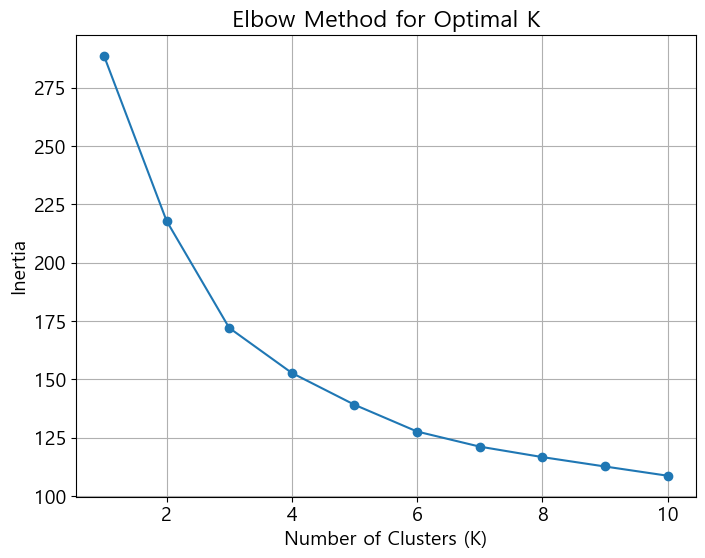

In [758]:
from sklearn.cluster import KMeans

inertia = []

# Define the range of K values to test
k_range = range(1, 11)  # You can adjust this range based on your problem

# Calculate the inertia for different K values
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(sca_df)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()
plt.close()

4개의 클러스터로 구분하는 것이 적절하다고 판단할 수 있다.

In [759]:
kmeans = KMeans(n_clusters=4)

y = kmeans.fit_predict(sca_df[['배수등급양호비율', '제방', '수문', '평균경사도(%)', '하천까지의거리(중심)', '인구밀도(명/km²)',
       '1분위소득가구비율(%)', '2분위소득가구비율(%)', '3분위소득가구비율(%)', '4분위소득가구비율(%)',
       '5분위소득가구비율(%)', '도로율', '노인_per', '장애인_per', '기초생활수급자_per', '추정면적당시우량(연간)', 'FREQUENCY']])
y

c:\Users\yis82\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  self.copy_x = copy_x


array([2, 3, 3, 3, 1, 1, 1, 1, 1, 0, 0, 2, 2, 0, 3, 2, 0, 1, 3, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 3, 1, 3, 0, 2, 1, 3, 1, 3, 3, 1, 3, 2, 3, 1,
       1, 1, 3, 2, 1, 3, 1, 0, 0, 0, 3, 3, 3, 3, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 3, 1, 3, 2, 2, 3, 3, 0, 1, 2, 3, 2, 3, 3, 2, 2, 2, 3, 2, 2, 2,
       2, 3, 3, 0, 3, 1, 0, 1, 0, 1, 1, 3, 0, 1, 1, 1, 0, 3, 0, 1, 3, 3,
       1, 0, 3, 0, 1, 1, 1, 0, 1, 0, 3, 1, 1, 3, 3, 3, 0, 2, 0, 2, 3, 2,
       2, 0, 3, 3, 3, 3, 0, 0, 1, 3, 3, 1, 3, 2, 1, 3, 0, 1, 1, 1, 1, 0,
       0, 3, 0, 3, 3, 3, 3, 3, 3, 0, 1, 3, 3, 0, 0, 1, 2, 0, 3, 3, 2, 1,
       3, 2, 1, 0, 0, 1, 1, 3, 2, 2, 3, 2, 0, 2, 2, 3, 1, 1, 3, 3, 2, 0,
       2, 0, 0, 1, 1, 0, 0, 3, 1, 2, 3, 0, 3, 0, 1, 2, 3, 1, 1, 0, 2, 2,
       0, 2, 1, 1, 3, 0, 2, 1, 3, 0, 1, 3, 0, 1, 3, 1, 0, 0, 1, 0, 0, 1,
       1, 3, 3, 1, 3, 1, 0, 3, 3, 0, 1, 2, 1, 0, 1, 1, 3, 1, 1, 1, 1, 1,
       3])

In [760]:
sca_df['label'] = y

In [761]:
from sklearn.metrics import silhouette_score, silhouette_samples
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [762]:
n = 4
kmeans = KMeans(n_clusters=n, random_state=777,n_init=10)
clusters = kmeans.fit_predict(sca_df)
print("silhouette_score:", silhouette_score(sca_df, clusters))

silhouette_score: 0.4270491138756017


In [763]:
sample_silhouette_values = silhouette_samples(sca_df, clusters)

for i in range(4):
    cluster_silhouette_values = sample_silhouette_values[clusters == i]
    print(f"클러스터 {i}: 평균 실루엣 점수 = {np.mean(cluster_silhouette_values)}")


클러스터 0: 평균 실루엣 점수 = 0.48448168532159785
클러스터 1: 평균 실루엣 점수 = 0.4061305461108675
클러스터 2: 평균 실루엣 점수 = 0.42884276580028324
클러스터 3: 평균 실루엣 점수 = 0.35590422807691574


In [764]:
freq_list = []
for i in range(4):
    results_avg = sca_df[sca_df['label']==i]['FREQUENCY'].mean()
    freq_list.append(results_avg)


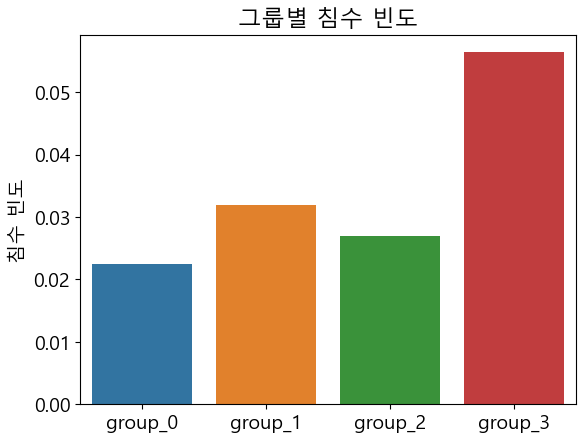

In [765]:
sb.barplot(x=['group_0', 'group_1', 'group_2', 'group_3'], y=freq_list)
plt.ylabel('침수 빈도')
plt.title('그룹별 침수 빈도')
plt.show()
plt.close()

In [807]:
from scipy.stats.mstats import gmean


In [766]:
def backward_elimination(X, y):
    included = list(X.columns)
    
    while True:
        model = sm.OLS(endog=y, exog=X[included]).fit()
        rsquard_adj = model.rsquared_adj
        worst_feature = None
        changed=False
        
        for feature in included:
            droped_feature=[x for x in included if x!=feature]
            droped_model=sm.OLS(endog=y, exog=X[droped_feature]).fit()
            if droped_model.rsquared_adj > rsquard_adj:
                #print(droped_model.rsquared_adj,rsquard_adj)
                worst_feature = feature
                break
        #print(included)
        if worst_feature:
            included.remove(worst_feature)
            changed = True
        
        if not changed:
            break
    
    model = sm.OLS(y,X[included]).fit()
    return model #, included, rsquard_adj

In [767]:
sca_df.drop(['FREQUENCY'],axis=1)
sca_df['FREQUENCY'] =df['FREQUENCY']

In [812]:
group_0 = sca_df[sca_df['label'] == 0]  
group_1 = sca_df[sca_df['label'] == 1]  
group_2 = sca_df[sca_df['label'] == 2]  
group_3 = sca_df[sca_df['label'] == 3]  

In [851]:
group_list = [group_0,group_1,group_2,group_3]

# 임계값 설정
vif_threshold = 10

# 열을 제거할 그룹 초기화
columns_to_remove = []

# 각 그룹에 대한 VIF 계산 및 열 제거
for i, group in enumerate(group_list):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = group.columns
    vif_data["VIF"] = [variance_inflation_factor(group.values, i) for i in range(group.shape[1])]

    # VIF가 임계값을 초과하는 열 확인
    high_vif_columns = vif_data[vif_data["VIF"] > vif_threshold]["Variable"].tolist()

    # 열 제거할 그룹 표시
    if high_vif_columns:
        print(f"Group {i} - High VIF columns to remove: {high_vif_columns}")
        columns_to_remove.extend(high_vif_columns)

# 중복된 열 제거
columns_to_remove = list(set(columns_to_remove))

# 열을 제거
for i, group in enumerate(group_list):
    group_list[i] = group.drop(columns=columns_to_remove)

# 업데이트된 그룹 확인
for i, group in enumerate(group_list):
    print(f"Group {i} - Updated DataFrame:")
    print(group)

Group 0 - High VIF columns to remove: ['1분위소득가구비율(%)', '2분위소득가구비율(%)', '3분위소득가구비율(%)', '4분위소득가구비율(%)', '5분위소득가구비율(%)', '장애인_per']
Group 1 - High VIF columns to remove: ['1분위소득가구비율(%)', '2분위소득가구비율(%)', '3분위소득가구비율(%)', '4분위소득가구비율(%)', '5분위소득가구비율(%)']
Group 2 - High VIF columns to remove: ['1분위소득가구비율(%)', '2분위소득가구비율(%)', '3분위소득가구비율(%)', '4분위소득가구비율(%)', '5분위소득가구비율(%)', '장애인_per', '기초생활수급자_per', '추정면적당시우량(연간)', 'label']
Group 3 - High VIF columns to remove: ['1분위소득가구비율(%)', '2분위소득가구비율(%)', '3분위소득가구비율(%)', '4분위소득가구비율(%)', '5분위소득가구비율(%)', '장애인_per', '기초생활수급자_per', 'label']
Group 0 - Updated DataFrame:
     배수등급양호비율   제방   수문  평균경사도(%)  하천까지의거리(중심)  인구밀도(명/km²)       도로율  \
9    0.294615  1.0  1.0  0.364250     0.199878     0.758740  0.347494   
10   0.531086  1.0  1.0  0.277186     0.035422     0.486754  0.347494   
13   0.540018  1.0  1.0  0.196517     0.162640     0.467794  0.227698   
16   0.694410  1.0  1.0  0.096186     0.137513     0.160792  0.609176   
19   0.683324  1.0  1.0  0.180914

c:\Users\yis82\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\yis82\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\yis82\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\yis82\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\yis82\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: i

In [847]:
group_list

[     배수등급양호비율   제방   수문  평균경사도(%)  하천까지의거리(중심)  인구밀도(명/km²)       도로율  \
 9    0.294615  1.0  1.0  0.364250     0.199878     0.758740  0.347494   
 10   0.531086  1.0  1.0  0.277186     0.035422     0.486754  0.347494   
 13   0.540018  1.0  1.0  0.196517     0.162640     0.467794  0.227698   
 16   0.694410  1.0  1.0  0.096186     0.137513     0.160792  0.609176   
 19   0.683324  1.0  1.0  0.180914     0.002281     0.515353  0.676296   
 28   0.752860  1.0  1.0  0.575693     0.537452     0.135277  0.153781   
 32   0.812007  1.0  1.0  0.511609     0.120671     0.086181  0.153781   
 51   0.893574  1.0  1.0  0.341349     0.141615     0.020349  0.549703   
 52   0.237152  1.0  1.0  0.024876     0.036005     0.623414  0.549703   
 53   0.533887  1.0  1.0  0.262082     0.204939     0.444859  0.417162   
 58   0.796617  1.0  1.0  0.412709     0.080716     0.292009  0.609176   
 59   0.518152  1.0  1.0  0.300995     0.118898     0.630927  0.227698   
 64   0.000000  1.0  1.0  0.000000    

In [860]:
# Initialize a dictionary to store the regression models
regression_models = {}
group_dict = {"group_0" : group_0, 
              "group_1" : group_1, 
              "group_2" : group_2, 
              "group_3" : group_3}
for group_name, group in group_dict.items():
    # Apply backward elimination and store the model in the dictionary
    regression_models[group_name] = backward_elimination(group.drop(['FREQUENCY'], axis=1), group['FREQUENCY'])


In [863]:
regression_models["group_0"].summary()

c:\Users\yis82\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\regression\linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              FREQUENCY   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     5.209
Date:                Tue, 31 Oct 2023   Prob (F-statistic):            0.00125
Time:                        00:25:05   Log-Likelihood:                -289.17
No. Observations:                  60   AIC:                             588.3
Df Residuals:                      55   BIC:                             598.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
배수등급양호비율       -28.0683     14.958     -1.876      0.066     -58.045       1.908
제방              38.4115      8.840      4.345      0.000      20.695      56.128
수문              38.4115      8.840      4.345      0.000      20.695      56.128
도로율            -68.6616     19.292     -3.559      0.001    -107.324     -29.999
노인_per         -36.5831     18.126     -2.018      0.048     -72.909      -0.258
추정면적당시우량(연간)    31.6516     22.242      1.423      0.160     -12.923      76.226
label                 0          0        nan        nan           0           0
==============================================================================
Omnibus:                       47.555   Durbin-Watson:                   1.775
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              180.321
Skew:                           2.297   Prob(JB):                     6.98e-40
Kurtosis:                      10.143   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [861]:
regression_models["group_1"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              FREQUENCY   R-squared (uncentered):                   0.288
Model:                            OLS   Adj. R-squared (uncentered):              0.234
Method:                 Least Squares   F-statistic:                              5.387
Date:                Tue, 31 Oct 2023   Prob (F-statistic):                    0.000102
Time:                        00:24:37   Log-Likelihood:                         -506.68
No. Observations:                  86   AIC:                                      1025.
Df Residuals:                      80   BIC:                                      1040.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
배수등급양호비율       -45.7837     32.606     -1.404      0.164    -110.673      19.105
인구밀도(명/km²)    111.4028     44.369      2.511      0.014      23.106     199.700
4분위소득가구비율(%)  -104.5548     51.974     -2.012      0.048    -207.987      -1.122
도로율            127.4523     34.690      3.674      0.000      58.417     196.488
장애인_per        200.8284     99.957      2.009      0.048       1.908     399.749
기초생활수급자_per   -200.0550     89.042     -2.247      0.027    -377.255     -22.855
==============================================================================
Omnibus:                      134.171   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5696.800
Skew:                           5.315   Prob(JB):                         0.00
Kurtosis:                      41.429   Cond. No.                         18.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [862]:
regression_models["group_2"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              FREQUENCY   R-squared (uncentered):                   0.329
Model:                            OLS   Adj. R-squared (uncentered):              0.274
Method:                 Least Squares   F-statistic:                              6.042
Date:                Tue, 31 Oct 2023   Prob (F-statistic):                     0.00187
Time:                        00:24:44   Log-Likelihood:                         -207.18
No. Observations:                  40   AIC:                                      420.4
Df Residuals:                      37   BIC:                                      425.4
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
3분위소득가구비율(%)    64.4571     17.363      3.712      0.001      29.277      99.637
노인_per         122.7109     89.612      1.369      0.179     -58.861     304.283
기초생활수급자_per   -120.3025     63.482     -1.895      0.066    -248.929       8.324
==============================================================================
Omnibus:                       37.430   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.921
Skew:                           2.384   Prob(JB):                     4.48e-23
Kurtosis:                       9.246   Cond. No.                         8.26
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [864]:
regression_models["group_3"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              FREQUENCY   R-squared (uncentered):                   0.482
Model:                            OLS   Adj. R-squared (uncentered):              0.440
Method:                 Least Squares   F-statistic:                              11.33
Date:                Tue, 31 Oct 2023   Prob (F-statistic):                    6.55e-09
Time:                        00:25:30   Log-Likelihood:                         -453.02
No. Observations:                  79   AIC:                                      918.0
Df Residuals:                      73   BIC:                                      932.3
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
하천까지의거리(중심)   -121.9262     53.159     -2.294      0.025    -227.871     -15.981
2분위소득가구비율(%)   386.1215     96.562      3.999      0.000     193.674     578.569
3분위소득가구비율(%)  -140.2106     72.003     -1.947      0.055    -283.712       3.291
5분위소득가구비율(%)    91.4875     74.814      1.223      0.225     -57.617     240.592
도로율             89.2519     30.739      2.904      0.005      27.990     150.514
기초생활수급자_per   -133.8144     45.499     -2.941      0.004    -224.493     -43.136
==============================================================================
Omnibus:                       40.970   Durbin-Watson:                   1.696
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.575
Skew:                           1.694   Prob(JB):                     1.08e-26
Kurtosis:                       7.985   Cond. No.                         17.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [773]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering


In [774]:
lnk = linkage(df, method='ward', metric = 'euclidean')
lnk

array([[4.70000000e+01, 2.01000000e+02, 1.86178004e+01, 2.00000000e+00],
       [1.67000000e+02, 2.36000000e+02, 2.76427472e+01, 2.00000000e+00],
       [2.09000000e+02, 2.38000000e+02, 3.40649049e+01, 2.00000000e+00],
       ...,
       [5.21000000e+02, 5.22000000e+02, 6.03660300e+04, 9.40000000e+01],
       [5.24000000e+02, 5.25000000e+02, 1.00566033e+05, 1.71000000e+02],
       [5.26000000e+02, 5.27000000e+02, 2.07430235e+05, 2.65000000e+02]])

## 모델생성

In [775]:
import sklearn.tree as sktree
import sklearn.preprocessing as skpre
import numpy as np
import sklearn.model_selection as skmod
np.random.seed(10)
plt.rcParams['font.family']="MALGUN GOTHIC" 

In [776]:
# feature_cols=['배수등급양호비율', '제방', '수문', '암거', '평균경사도(%)',
#        '하천까지의거리(중심)', '인구밀도(명/km²)', '도로율', '노인_per', '장애인_per', '기초생활수급자_per',
#        '기초생활수급자+65세이상_per', '추정시우량(연간)']
target_cols=["침수여부"]
feature_cols=통합.columns.difference(["GU_NAME","ADM_NM"]+target_cols)

In [777]:
train,test=skmod.train_test_split(통합,train_size=0.7,random_state=13)

In [778]:
params_model=sktree.DecisionTreeClassifier(criterion="entropy")
params_model.fit(X=train[feature_cols],y=train[target_cols])

DecisionTreeClassifier(criterion='entropy')

In [779]:
params_model.score(X=test[feature_cols],y=test[target_cols])

0.7213114754098361

In [780]:
print("max_depth :",params_model.get_depth())
print("max_sample_size :",params_model.get_n_leaves())

max_depth : 13
max_sample_size : 55


In [781]:
plt.figure()
sktree.plot_tree(params_model,filled=True)
plt.savefig("tree.png",dpi=1000,bbox_inches='tight')
plt.close()

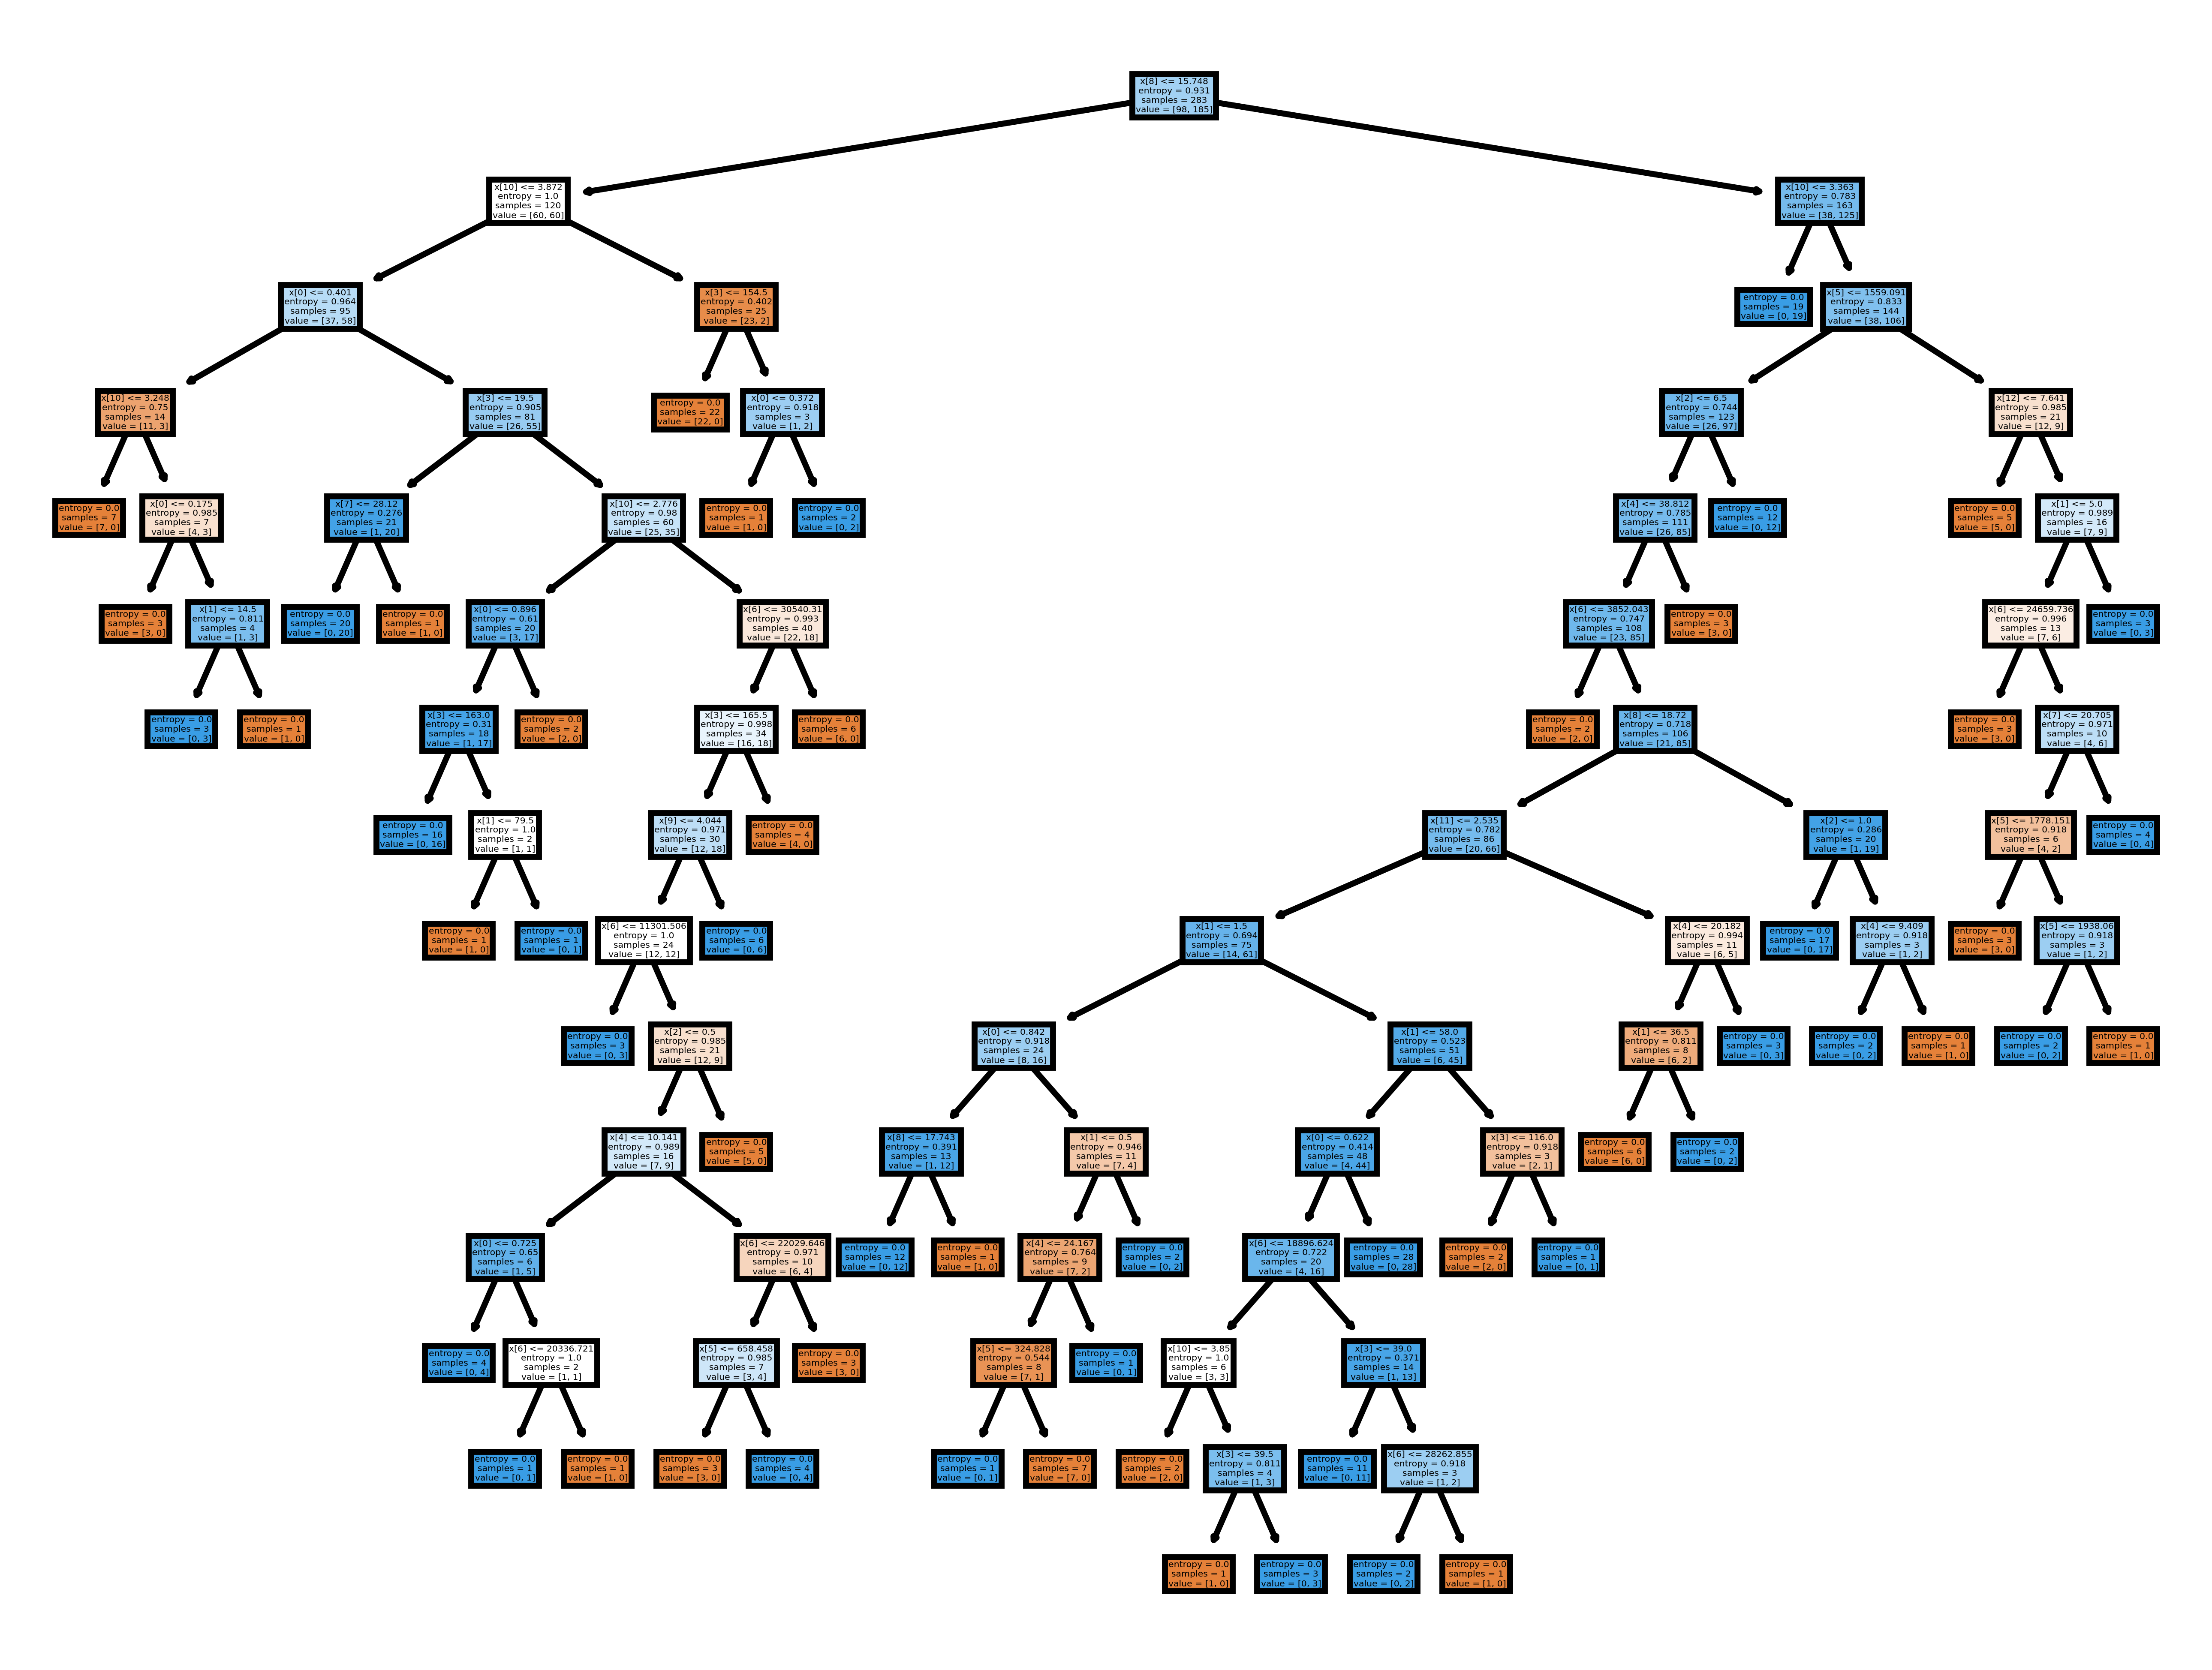

In [782]:
# 위와 같은 과정을 진행할것.
params_model=sktree.DecisionTreeClassifier(criterion="entropy")
params_model.fit(X=통합[feature_cols],y=통합[target_cols])
max_depth,max_sample_size=params_model.get_depth(),params_model.get_n_leaves()
print("max_depth :",params_model.get_depth())
print("max_sample_size :",params_model.get_n_leaves())

max_depth : 15
max_sample_size : 68


### 파라미터 최적화

random_search 로 탐색해보겠음..
- 학습 500번
- cv=10

test 사이즈와 똑같이 나누기

-------

In [783]:
import scipy as sp

In [784]:
params={"max_depth":sp.stats.randint(low=2,high=max_depth),"min_samples_split":sp.stats.randint(low=2,high=max_sample_size)}
grid_tree=sktree.DecisionTreeClassifier(criterion="entropy",random_state=13)
Random_model=skmod.RandomizedSearchCV(grid_tree,param_distributions=params,cv=10,random_state=13,n_iter=500,n_jobs=-1
                                      ,scoring="accuracy")
Random_model.fit(X=통합[feature_cols],y=통합[target_cols])

RandomizedSearchCV(cv=10,
                   estimator=DecisionTreeClassifier(criterion='entropy',
                                                    random_state=13),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F070816DF0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F006AFF520>},
                   random_state=13, scoring='accuracy')

In [785]:
Random_model.best_params_

{'max_depth': 12, 'min_samples_split': 51}

In [786]:
Random_model.score(X=test[feature_cols],y=test[target_cols])

0.819672131147541

In [787]:
best_model = sktree.DecisionTreeClassifier(criterion="entropy",min_samples_split=51, max_depth =12)
best_model.fit(X=train[feature_cols],y=train[target_cols])
best_model.score(X=test[feature_cols],y=test[target_cols])

0.7622950819672131

# 위의 과정이 지금 재현이 안됌...

In [788]:
print('결과 :',Random_model.best_params_)

결과 : {'max_depth': 12, 'min_samples_split': 51}


위의 결과를 토대로 의사결정나무를 만들것

### 부트스트랩
40개의 데이터 셋 구현 -> 침수여부의 층화추출이 이루어져야 됨

In [789]:
import sklearn.utils as skuti

In [790]:
from sklearn.ensemble import BaggingClassifier

In [791]:
bag_clf = BaggingClassifier(sktree.DecisionTreeClassifier(), n_estimators=50, max_samples = 100, n_jobs=-1,random_state=42 ,oob_score=True)
bag_clf.fit(train[feature_cols],train[target_cols])

c:\Users\yis82\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\yis82\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  if pickle_version != __version__:


BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=50, n_jobs=-1, oob_score=True, random_state=42)

In [792]:
bag_clf.score(test[feature_cols],test[target_cols])

0.7540983606557377

In [793]:
import sklearn.utils as skuti
for i in range(11,11+40):
    eval(f'np.random.seed({i})') # 랜덤시드 11~51번까지 고정
resample_data={'train':[],'test':[]}
for i in range(11,11+40):
    resample_train,resample_test=skmod.train_test_split(통합,train_size=0.7,random_state=i-1,stratify=통합[target_cols])
    resample_data["train"].append(resample_train)
    resample_data["test"].append(resample_test)
tree_model=sktree.DecisionTreeClassifier(max_depth=Random_model.best_params_["max_depth"]
                                         ,min_samples_split=Random_model.best_params_["min_samples_split"]
                                         ,random_state=10,
                                         criterion="entropy")
acc_list=[]
for i in range(40):
    tree_model.fit(X=resample_data["train"][i][feature_cols],y=resample_data["train"][i][target_cols])
    acc_list.append(tree_model.score(X=resample_data['test'][i][feature_cols],y=resample_data['test'][i][target_cols]))

In [794]:
Random_model.best_params_

{'max_depth': 12, 'min_samples_split': 51}

In [795]:
나무결과=pd.DataFrame(acc_list).rename(columns={0:'accuracy'})
나무결과["테스트_오차율"]=1-나무결과["accuracy"]
나무결과.sort_values(by="테스트_오차율",inplace=True)

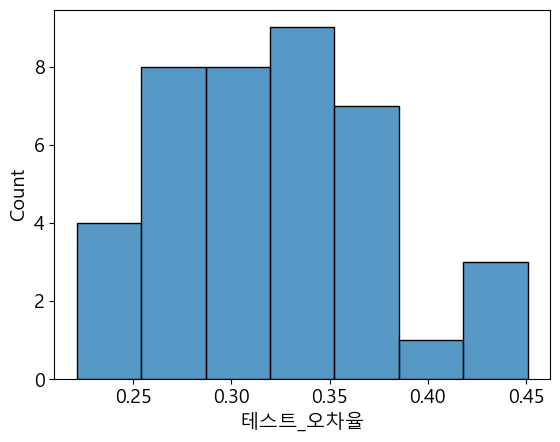

In [796]:
import seaborn as sb
plt.figure()
sb.histplot(x=나무결과["테스트_오차율"])
plt.show()
plt.close()

#### 가설검정
일반화 오차율

In [797]:
나무결과["테스트_오차율"].median()

0.3155737704918033

In [798]:
sp.stats.ttest_1samp(나무결과["테스트_오차율"],0.17)

TtestResult(statistic=17.676631089145737, pvalue=3.2281401249947487e-20, df=39)

일반화 오차율은 23%로 예상됨.           
즉, 일반화 accuracy는 77%

## 결과해석

In [799]:
final_tree_model=sktree.DecisionTreeClassifier(max_depth=Random_model.best_params_["max_depth"]
                                               ,min_samples_split=Random_model.best_params_["min_samples_split"]
                                               ,random_state=10
                                               ,criterion="entropy")
final_tree_model.fit(X=통합[feature_cols],y=통합[target_cols])

DecisionTreeClassifier(criterion='entropy', max_depth=12, min_samples_split=51,
                       random_state=10)

In [800]:
info_result=pd.DataFrame(list(zip(final_tree_model.feature_names_in_,final_tree_model.feature_importances_))).rename(columns={0:"feature_name",1:"infomation_gain"})
info_result["infomation_gain"]=info_result["infomation_gain"].apply(lambda x:x*100)
info_result.sort_values(by="infomation_gain",ascending=False,inplace=True)
info_result.to_csv("./information_gain.csv")

In [801]:
info_result

,feature_name,infomation_gain
6,기초생활수급자_per,28.039406
7,노인_per,16.129926
1,2분위소득가구비율(%),10.243962
12,장애인_per,9.802462
2,3분위소득가구비율(%),7.807660
3,4분위소득가구비율(%),7.678923
11,인구밀도(명/km²),6.536399
9,배수등급양호비율,5.447680
16,하천까지의거리(중심),3.163716
0,1분위소득가구비율(%),2.700453


In [802]:
plt.figure()
sktree.plot_tree(final_tree_model,filled=True,feature_names=feature_cols)
plt.savefig("final_tree.png",dpi=1000,bbox_inches='tight')
plt.close()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\yis82\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\yis82\AppData\Local\Temp\ipykernel_86680\3851673859.py", line 2, in <module>
    sktree.plot_tree(final_tree_model,filled=True,feature_names=feature_cols)
  File "c:\Users\yis82\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\_param_validation.py", line 201, in wrapper
    to_ignore += ["self", "cls"]
  File "c:\Users\yis82\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
sklearn.utils._param_validation.InvalidParameterError: The 'feature_names' parameter of plot_tree must be an instance of 'list' or None. Got Index(['1분위소득가구비율(%)', '2분위소득가구비율(%)', '3분위소득가구비율(%)', '4분위소득가구비율(%)',
       '5분위소득가구비율(%)', '기초생활수급자+65세이상_per', '기초생활수급자_per', '노인_per', 

<Figure size 640x480 with 0 Axes>

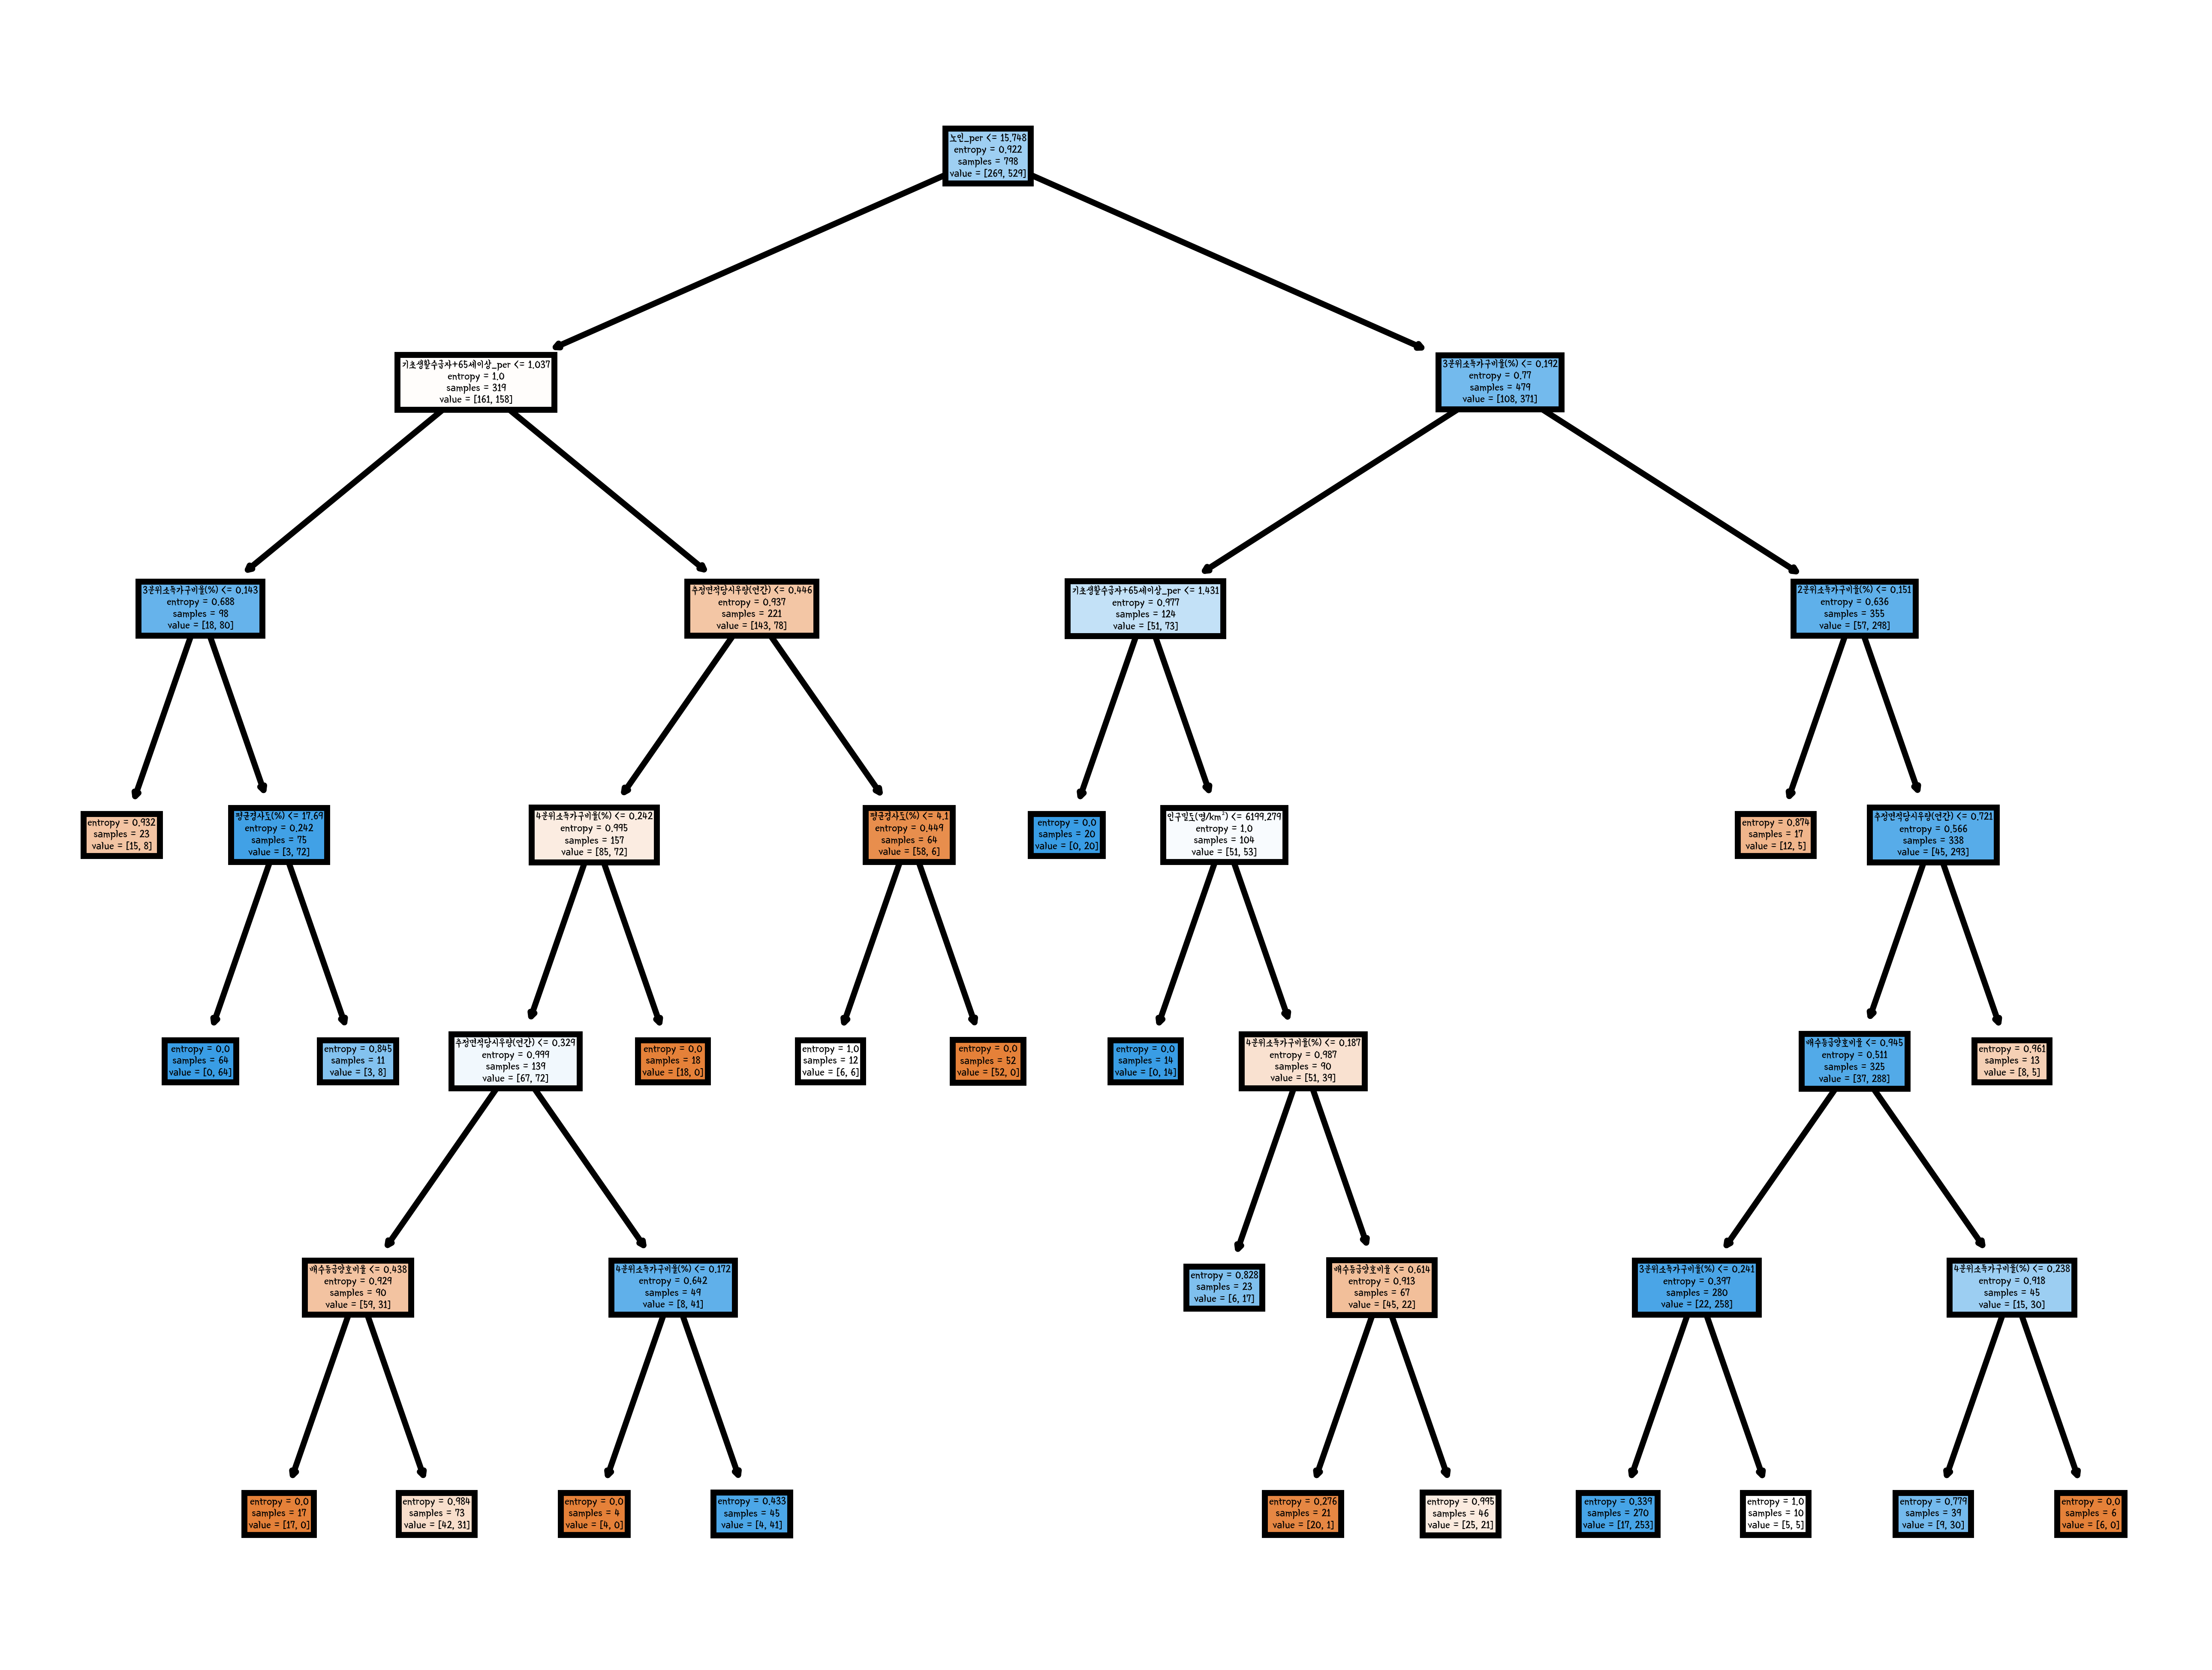